## Загрузим нужные библиотеки

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

!pip install category_encoders
from category_encoders.binary import BinaryEncoder
#Установка catboost
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [33]:
df = pd.read_csv("../input/amamam/train_dataset_train.csv")
df_test = pd.read_csv("../input/amamam/test_dataset_test.csv") #, nrows = 100000


In [34]:
#Для каждой станции считаем среднюю длину ее оптимальных путей. Маленькие длины будут у центральных станций.

subway = pd.read_csv("../input/subway/subway.csv")
subway = subway[subway.optimal_route_delta == 0]
subway2 = subway.groupby('start_station_nm',as_index = False).agg({'route_dur': 'mean'})
subway2



,start_station_nm,route_dur
0,Авиамоторная,34.503543
1,Автозаводская,31.383381
2,Академическая,31.856038
3,Александровский сад,26.863584
4,Алексеевская,30.590000
...,...,...
287,Электрозаводская,34.101190
288,Юго-Восточная,46.934294
289,Юго-Западная,37.577775
290,Южная,39.332775


## Рассмотрим датасет по ближе

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091021 entries, 0 to 1091020
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1091021 non-null  int64  
 1   ticket_id       1091021 non-null  object 
 2   ticket_type_nm  1091021 non-null  object 
 3   entrance_id     1091021 non-null  int64  
 4   entrance_nm     1091021 non-null  object 
 5   station_id      1091021 non-null  int64  
 6   station_nm      1091021 non-null  object 
 7   line_id         1091021 non-null  int64  
 8   line_nm         1091021 non-null  object 
 9   pass_dttm       1091021 non-null  object 
 10  time_to_under   1091021 non-null  float64
 11  label           1091021 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 99.9+ MB


In [36]:
df = pd.concat([df,df_test])

df["ticket_type_nm"] = pd.Categorical(df["ticket_type_nm"])
bn4 = BinaryEncoder()
df = pd.concat([df, bn4.fit_transform(df.ticket_type_nm)], axis = 1)
df.ticket_type_nm = df.ticket_type_nm.cat.codes
df.ticket_type_nm = df.ticket_type_nm.astype('int')

df["line_id"] = pd.Categorical(df["line_id"])
df["line_id"].astype('category').cat.codes
bn = BinaryEncoder()
df = pd.concat([df, bn.fit_transform(df.line_id)], axis = 1)
df.line_id = df.line_id.cat.codes
df.line_id = df.line_id.astype('int')

df["station_id"] = pd.Categorical(df["station_id"])
df["station_id"].astype('category').cat.codes
bn2 = BinaryEncoder()
df = pd.concat([df, bn2.fit_transform(df.station_id)], axis = 1)
df.station_id = df.station_id.cat.codes
df.station_id = df.station_id.astype('int')

df["entrance_id"] = pd.Categorical(df["entrance_id"])
df["entrance_id"].astype('category').cat.codes
bn3 = BinaryEncoder()
df = pd.concat([df, bn3.fit_transform(df.entrance_id)], axis = 1)
df.entrance_id = df.entrance_id.cat.codes
df.entrance_id = df.entrance_id.astype('int')

df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
df["hours"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

df = df.merge(subway2, how = 'left', right_on = 'start_station_nm', left_on = 'station_nm')
df = df.drop(["entrance_nm", "station_nm", "line_nm", "entrance_id", "station_id", "line_id",'start_station_nm'], axis = 1)

df_test = df[1091021:]
df = df[:1091021]
df.label = df.label.astype(int)

df

,id,ticket_id,ticket_type_nm,pass_dttm,time_to_under,label,ticket_type_nm_0,ticket_type_nm_1,ticket_type_nm_2,ticket_type_nm_3,...,entrance_id_2,entrance_id_3,entrance_id_4,entrance_id_5,entrance_id_6,entrance_id_7,entrance_id_8,day,hours,route_dur
0,1,40BD89EC85646EFB69E283F39C298E60,40,2022-09-12 05:00:13,216.316667,8001,0,0,0,0,...,0,0,0,0,0,0,1,12,5,38.700476
1,2,126727A96489CC976A8C08E5CEB00542,54,2022-09-12 05:00:54,648.183333,9011,0,0,0,0,...,0,0,0,0,0,1,0,12,5,33.374255
2,3,D28CE6A9E0E5B6D213470A97CFF32485,26,2022-09-12 05:00:55,865.333333,7022,0,0,0,0,...,0,0,0,0,0,1,0,12,5,33.374255
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,3,2022-09-12 05:01:13,1048.233333,2022,0,0,0,1,...,0,0,0,0,0,1,0,12,5,33.374255
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,38,2022-09-12 05:02:55,965.600000,2017,0,0,0,1,...,0,0,0,0,0,1,0,12,5,33.374255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,1091017,6A738232F8E43DFCD4027FDC0EA6CC03,40,2022-09-19 02:54:50,124.750000,15005,0,0,0,0,...,0,0,1,0,0,1,0,19,2,39.803552
1091017,1091018,141174B366F14A8703903813A49374DB,40,2022-09-19 03:06:02,56.066667,6007,0,0,0,0,...,1,1,1,1,1,0,1,19,3,34.552123
1091018,1091019,E38493B30A7C55170806F187AF5EEA15,40,2022-09-19 03:17:00,91.283333,2010,0,0,0,0,...,0,1,0,1,1,1,0,19,3,35.832283
1091019,1091020,3DF2B6366631ECA06274DD2CB5B0DF24,40,2022-09-19 03:23:30,47.900000,11014,0,0,0,0,...,1,0,1,0,0,0,0,19,3,34.154335


Кажется нет четкой зависимости между категорией билета и временем между заходи на станцию

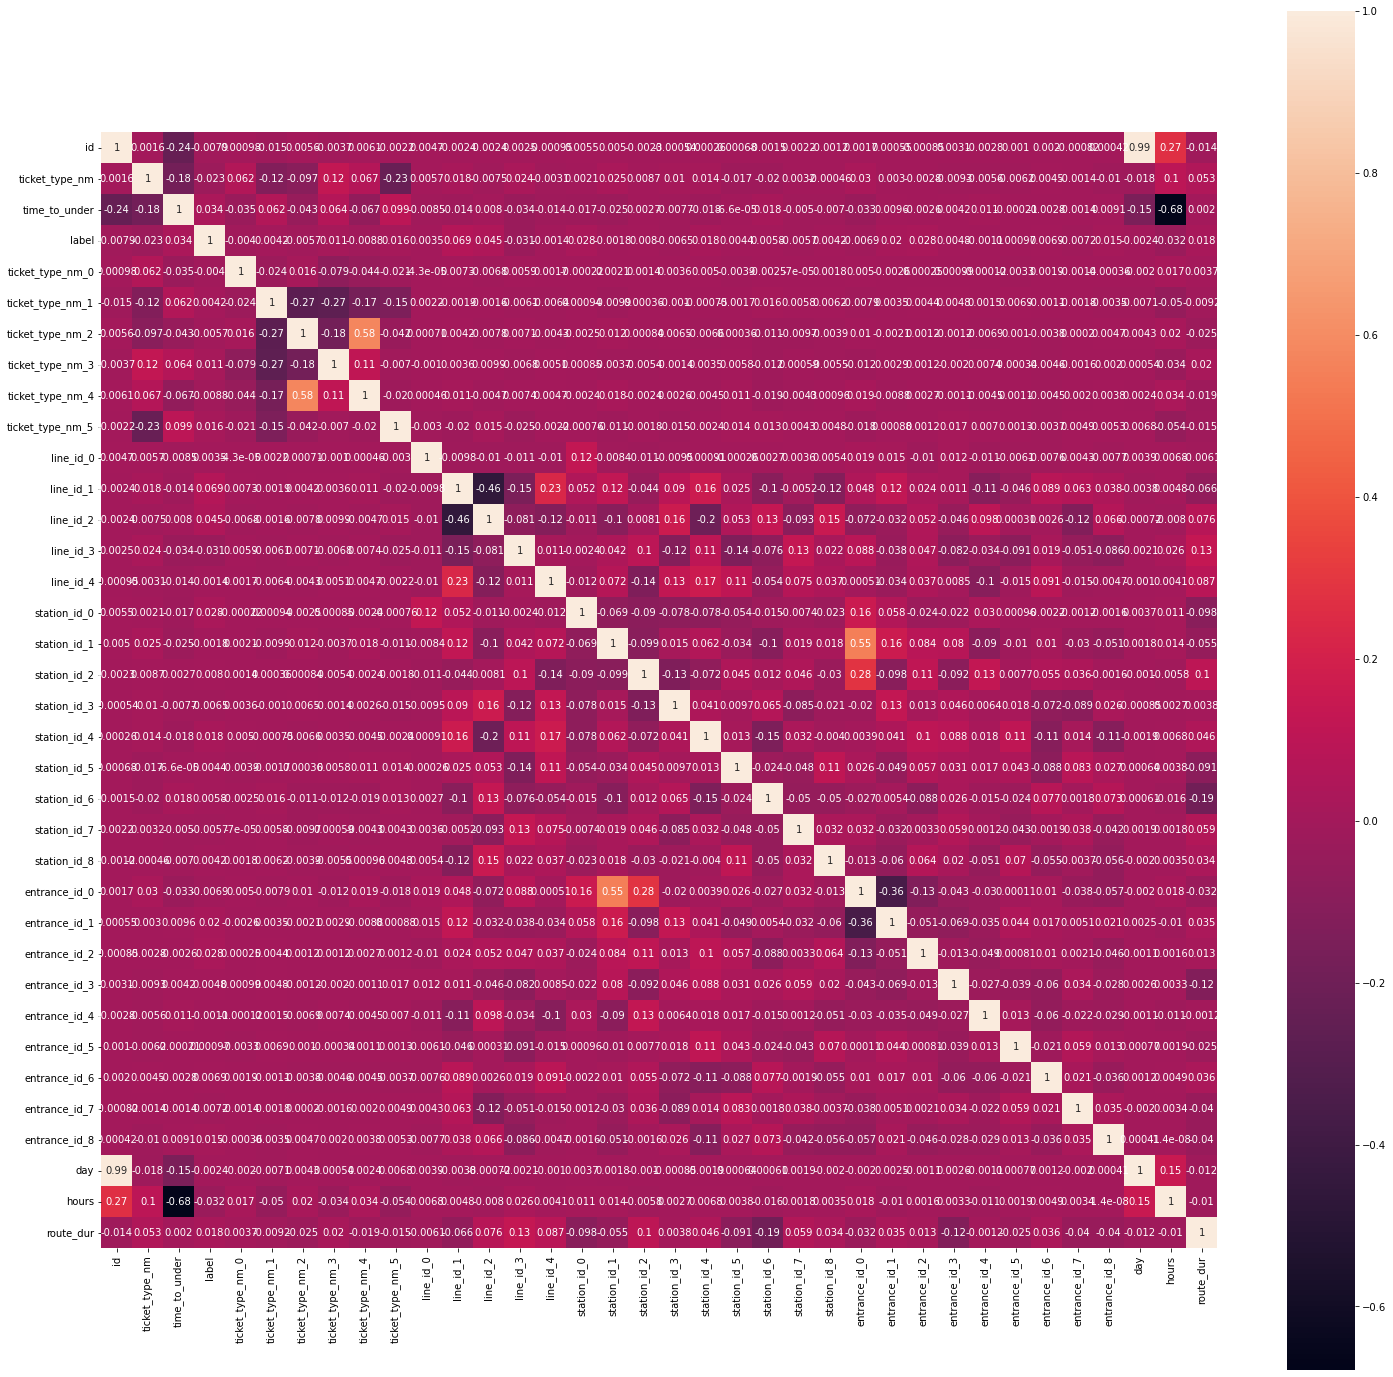

In [37]:
plt.rcParams['figure.figsize']=(25,25)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [38]:
X = df.drop(["ticket_id", "pass_dttm", "label","time_to_under",'id'], axis = 1) #,"ticket_type_nm"
y = df[["label"]]

X2 = df.drop(["ticket_id", "pass_dttm", "label","time_to_under",'id'], axis = 1) #,"ticket_type_nm"
y2 = df[["time_to_under"]]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.01, random_state=42)

In [40]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763714 entries, 783111 to 121958
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   label   763714 non-null  int64
dtypes: int64(1)
memory usage: 11.7 MB


## Обучение модели

Для станции

In [41]:
pool_train2 = Pool(X_train, y_train)

model2 = CatBoostClassifier(task_type='GPU', iterations = 300, learning_rate=0.03, l2_leaf_reg=0.001)
model2.fit(pool_train2,plot=True)
model2.feature_importances_



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5.5486969	total: 2.71s	remaining: 13m 29s
1:	learn: 5.4961124	total: 5.39s	remaining: 13m 22s
2:	learn: 5.4531032	total: 7.82s	remaining: 12m 54s
3:	learn: 5.4159731	total: 10.3s	remaining: 12m 40s
4:	learn: 5.3832410	total: 12.9s	remaining: 12m 40s
5:	learn: 5.3529993	total: 15.3s	remaining: 12m 30s
6:	learn: 5.3256671	total: 17.8s	remaining: 12m 22s
7:	learn: 5.3006865	total: 20.2s	remaining: 12m 16s
8:	learn: 5.2762913	total: 22.8s	remaining: 12m 17s
9:	learn: 5.2551570	total: 25.3s	remaining: 12m 14s
10:	learn: 5.2346985	total: 27.8s	remaining: 12m 10s
11:	learn: 5.2159477	total: 30.3s	remaining: 12m 6s
12:	learn: 5.1976270	total: 32.8s	remaining: 12m 3s
13:	learn: 5.1811450	total: 35.7s	remaining: 12m 9s
14:	learn: 5.1653571	total: 38.3s	remaining: 12m 7s
15:	learn: 5.1506601	total: 40.8s	remaining: 12m 4s
16:	learn: 5.1366415	total: 43.3s	remaining: 12m 1s
17:	learn: 5.1234494	total: 46s	remaining: 12m
18:	learn: 5.1107345	total: 48.5s	remaining: 11m 57s
19:	learn: 5.09

array([7.20753978e+00, 4.52902659e-01, 2.02615816e+00, 9.52136199e-01,
       2.28714641e+00, 1.67446969e+00, 1.50251605e+00, 1.29999906e-04,
       6.64317634e+00, 7.22245822e+00, 6.34048716e+00, 6.50599445e+00,
       1.89582884e-01, 1.32935096e+00, 2.06451199e+00, 1.85287165e+00,
       1.90461530e+00, 1.91662441e+00, 1.92648430e+00, 2.19764609e+00,
       2.02027225e+00, 1.43784009e+00, 1.13853952e+00, 1.77275487e+00,
       1.61538342e+00, 1.26592409e+00, 1.36333765e+00, 1.63604939e+00,
       1.82075026e+00, 2.10374204e+00, 2.87662350e+00, 1.46808231e+01,
       1.00711572e+01])

In [42]:
pool_train = Pool(X_train2, y_train2)
pool_test = Pool(X_test)
pool_test2 = Pool(X_test2)

In [43]:
# from sklearn.model_selection import GridSearchCV

# model3 = CatBoostRegressor(task_type='GPU')
# Grid_CBC = GridSearchCV(estimator=model3, param_grid = params, cv = 2, n_jobs=-1)
# Grid_CBC.fit(X_train, y_train["time_to_under"])

# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [44]:
model = CatBoostRegressor(task_type = 'GPU', iterations = 4000, l2_leaf_reg = 0.001, border_count = 512) 

model.fit(pool_train,plot=True)
model.feature_importances_


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 229.4585872	total: 118ms	remaining: 7m 52s
1:	learn: 226.2239450	total: 156ms	remaining: 5m 12s
2:	learn: 223.1371645	total: 223ms	remaining: 4m 57s
3:	learn: 220.1880686	total: 276ms	remaining: 4m 35s
4:	learn: 217.3748380	total: 327ms	remaining: 4m 20s
5:	learn: 214.6954216	total: 391ms	remaining: 4m 20s
6:	learn: 212.1387838	total: 476ms	remaining: 4m 31s
7:	learn: 209.7039811	total: 557ms	remaining: 4m 37s
8:	learn: 207.3476851	total: 600ms	remaining: 4m 25s
9:	learn: 205.1047385	total: 662ms	remaining: 4m 24s
10:	learn: 203.0000842	total: 704ms	remaining: 4m 15s
11:	learn: 200.9667880	total: 804ms	remaining: 4m 27s
12:	learn: 199.0364378	total: 848ms	remaining: 4m 19s
13:	learn: 197.2151525	total: 910ms	remaining: 4m 19s
14:	learn: 195.4770378	total: 952ms	remaining: 4m 13s
15:	learn: 193.8000984	total: 995ms	remaining: 4m 7s
16:	learn: 192.2089317	total: 1.05s	remaining: 4m 6s
17:	learn: 190.6910488	total: 1.09s	remaining: 4m 1s
18:	learn: 189.2611372	total: 1.13s	remai

array([2.13321922e+01, 3.35567840e-01, 1.48268756e+00, 4.96912266e-01,
       1.79235188e+00, 1.64000704e+00, 1.98425239e+00, 9.11746252e-03,
       4.61050410e-01, 5.66684736e-01, 3.60002179e-01, 4.40496808e-01,
       1.19571079e-01, 1.77334089e-01, 2.35900117e-01, 2.74661568e-01,
       3.18884607e-01, 2.83730727e-01, 2.53785497e-01, 2.70355689e-01,
       3.07440232e-01, 3.34230535e-01, 2.52092126e-01, 2.48767848e-01,
       2.99504546e-01, 2.28601738e-01, 2.22212425e-01, 2.58870897e-01,
       2.49380294e-01, 2.53436726e-01, 4.91874898e+00, 5.62865557e+01,
       3.30461177e+00])

## Оценка точности

In [45]:
# pred_class = clf.predict(X_test)
# pred_reg = reg.predict(X_test)
pred_reg = model.predict(pool_test2)
pred_class = model2.predict(pool_test)

In [46]:
from sklearn.metrics import recall_score, r2_score


score = 0.5 * recall_score(y_test["label"], pred_class , average='macro') +  0.5 * r2_score(y_test2["time_to_under"], pred_reg)
print('Part Classifier ', recall_score(y_test["label"], pred_class , average='macro'))
print('Part Regressor ', r2_score(y_test2["time_to_under"], pred_reg))
score
# 0.2987724752412378 learning_rate=0.03, l2_leaf_reg=0.001 (0,065) на clsfcth
# 0.3017077625131806 категориальная переменная в бинари енкодер + осталась сама по себе + не факт что с результатом средний путь + 300 шагов catboost
# 0.30165820699814677 border_count = 256
# 0.3019404004722317 4000 iterations 512 border
# 0.3034320586758655 - с удалением выбросов (но это может быть и оттого, что те самые выбросы удалены!)

Part Classifier  0.07047989914894695
Part Regressor  0.5421690279455105


0.3063244635472287

# Работа с тестовой выборкой

In [47]:
df_test2 = df_test.drop(["ticket_id", "pass_dttm", "label", "time_to_under",'id'], axis = 1)

pool_otvet = Pool(df_test2)
time_to_under = model.predict(pool_otvet)
label = model2.predict(pool_otvet)

label

array([[6009],
       [3016],
       [6009],
       ...,
       [1003],
       [6020],
       [3016]])

In [48]:
otvet = df_test[{'id'}]
otvet['time_to_under'] = time_to_under
otvet['label'] = label

otvet

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,time_to_under,label
1091021,1091022,716.908135,6009
1091022,1091023,406.732926,3016
1091023,1091024,605.121259,6009
1091024,1091025,716.598689,2004
1091025,1091026,716.908135,6009
...,...,...,...
1652906,1652907,82.819879,6020
1652907,1652908,27.450007,11021
1652908,1652909,128.007581,1003
1652909,1652910,51.225409,6020


In [49]:
otvet.to_csv('otvet.csv', index=None)

216846
466781


<AxesSubplot:>

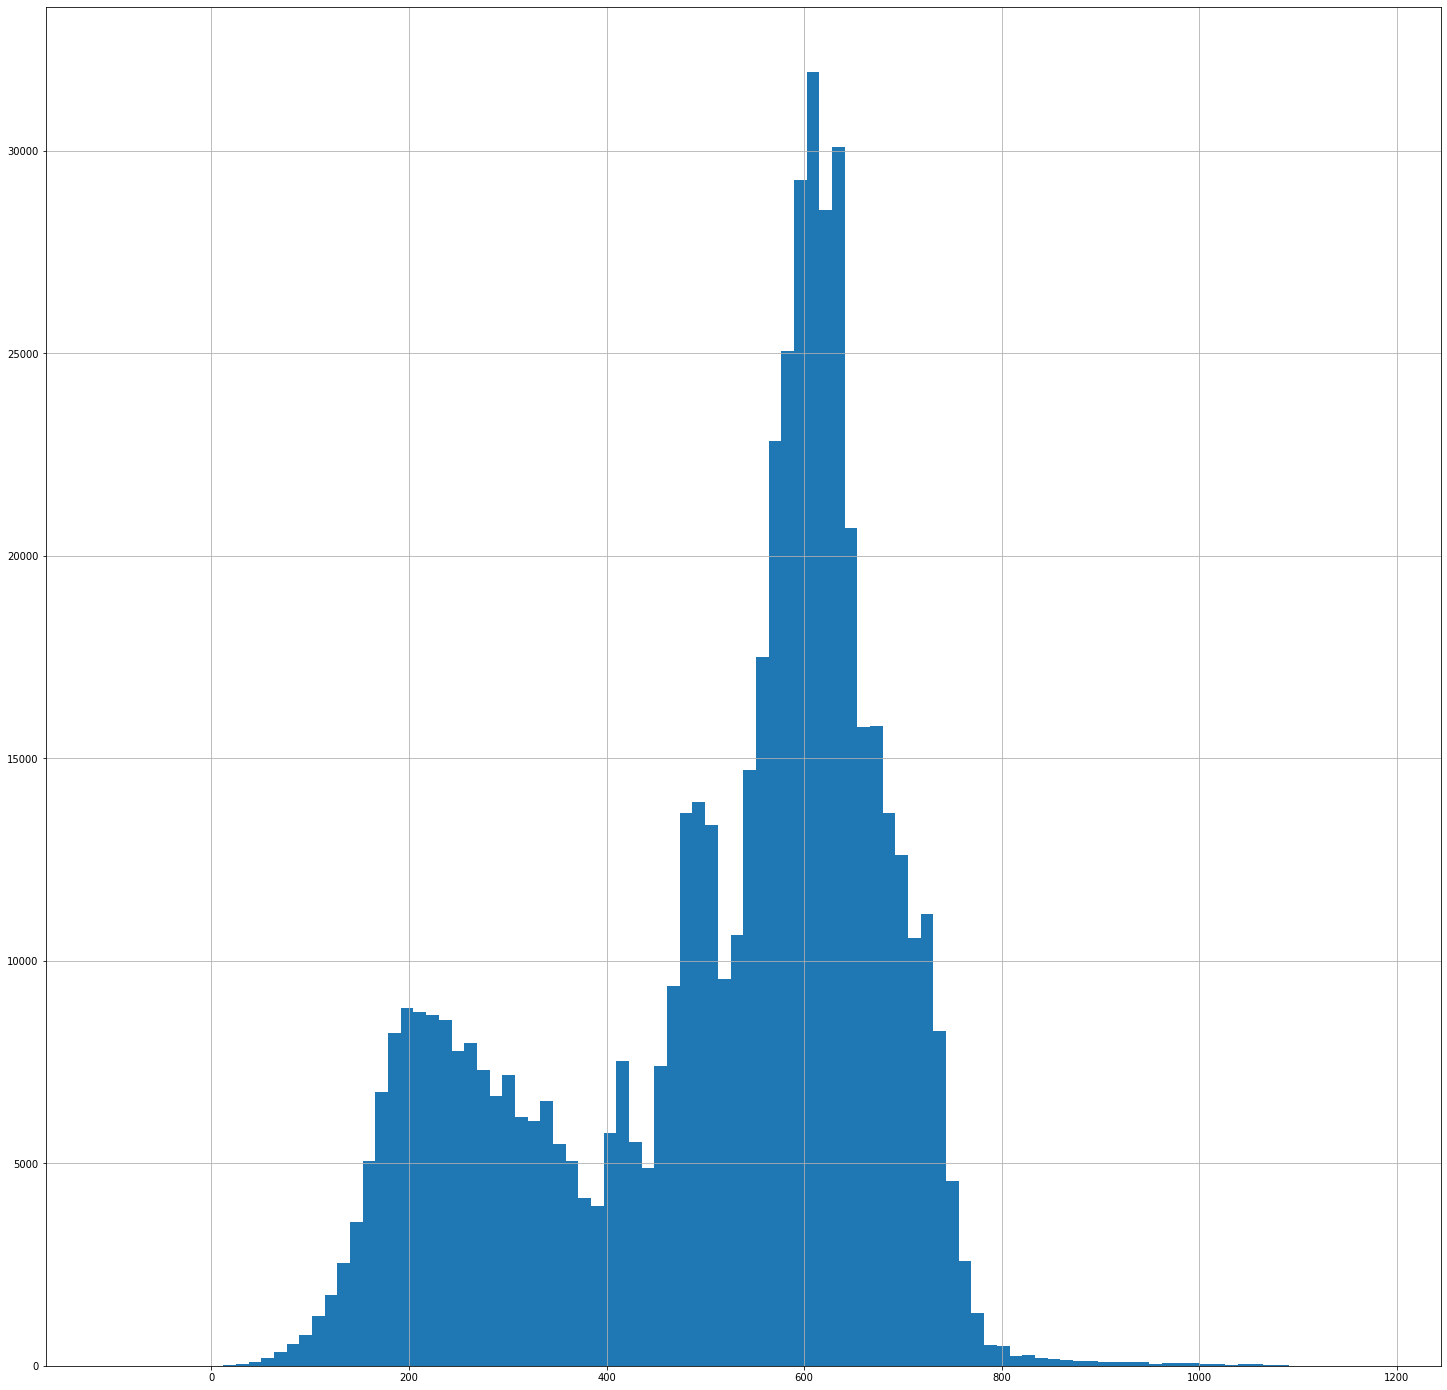

In [50]:
print(otvet.time_to_under[otvet.time_to_under > 600].count())
print(df.time_to_under[df.time_to_under > 600].count())
otvet.time_to_under.hist(bins = 100)